In [ ]:
from utils.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils.LSTM import *
import yaml

In [2]:
# with open("config.yaml", 'r') as file:
#             config_data = yaml.safe_load(file)
            
# dfs = dowload_tickers(config_data)

stock = "AMD"

df = pd.read_csv(f"./prices/{stock}_prices.csv", index_col=0, parse_dates=True)

In [3]:
start_day    = "2025-01-01"

horizon_days = 50                           # cantidad de días hábiles a predecir
training_years = 2                         # años previos para entrenar y predecir cada día

feat_cols = ["Close"]

In [ ]:
# TRAINING
##########
results = []
hit_coefs = [0, 0.001, 0.01, 0.05, 0.1, 0.25, 0.3, 0.5, 0.8, 1, 1.2, 1.5, 1.7, 2]
for hit_coef in hit_coefs:
    res = walk_forward_predict(     LSTMRegressor,
                                    df, 
                                    start_day, 
                                    horizon_days,
                                    training_years=training_years,
                                    feat_cols=feat_cols,

                                    W=50,
                                    
                                    hidden_size=64, 
                                    num_layers=2, 
                                    dropout=0.5,
                                    hit_coef=hit_coef,
                                    batch_size=11, 
                                    epochs=30, 
                                    lr=0.005,

                                    patience=10,
                                    loss_validation=True,
                                    
                                    torch_seed=0
                                )
    
    res_df = res[0]
    mse = float(np.mean((res_df["y_pred_norm"] - res_df["y_true_norm"])**2))
    _hit_rate = hit_rate(res[0], df)
    print(f"hit_coef = {hit_coef} | MSE = {mse:.6} | Hit Rate = {_hit_rate:.2%} ")
    results.append({
        "stock": stock,
        "hit_coef":hit_coef,
        "res":res,
        "mse":mse
    })

Processing test days: 100%|██████████| 50/50 [03:23<00:00,  4.08s/it]


hit_coef = 0 | MSE = 0.000967447 | Hit Rate = 52.00% 


Processing test days: 100%|██████████| 50/50 [03:27<00:00,  4.14s/it]


hit_coef = 0.001 | MSE = 0.000844268 | Hit Rate = 48.00% 


Processing test days: 100%|██████████| 50/50 [03:24<00:00,  4.09s/it]


hit_coef = 0.01 | MSE = 0.000879234 | Hit Rate = 64.00% 


Processing test days: 100%|██████████| 50/50 [03:25<00:00,  4.12s/it]


hit_coef = 0.05 | MSE = 0.000960887 | Hit Rate = 52.00% 


Processing test days: 100%|██████████| 50/50 [04:29<00:00,  5.38s/it]


hit_coef = 0.1 | MSE = 0.000949731 | Hit Rate = 54.00% 


Processing test days: 100%|██████████| 50/50 [05:47<00:00,  6.96s/it]


hit_coef = 0.25 | MSE = 0.00100832 | Hit Rate = 48.00% 


Processing test days: 100%|██████████| 50/50 [06:13<00:00,  7.47s/it]


hit_coef = 0.3 | MSE = 0.0010216 | Hit Rate = 48.00% 


Processing test days: 100%|██████████| 50/50 [05:20<00:00,  6.41s/it]


hit_coef = 0.5 | MSE = 0.000965033 | Hit Rate = 54.00% 


Processing test days: 100%|██████████| 50/50 [03:48<00:00,  4.57s/it]


hit_coef = 0.8 | MSE = 0.000849215 | Hit Rate = 62.00% 


Processing test days: 100%|██████████| 50/50 [05:01<00:00,  6.04s/it]


hit_coef = 1 | MSE = 0.00126473 | Hit Rate = 56.00% 


Processing test days: 100%|██████████| 50/50 [05:01<00:00,  6.03s/it]


hit_coef = 1.2 | MSE = 0.00115149 | Hit Rate = 48.00% 


Processing test days: 100%|██████████| 50/50 [04:39<00:00,  5.60s/it]


hit_coef = 1.5 | MSE = 0.00261225 | Hit Rate = 52.00% 


Processing test days: 100%|██████████| 50/50 [04:34<00:00,  5.48s/it]


hit_coef = 1.7 | MSE = 0.00263467 | Hit Rate = 48.00% 


Processing test days: 100%|██████████| 50/50 [04:12<00:00,  5.06s/it]

hit_coef = 2 | MSE = 0.00120749 | Hit Rate = 50.00% 


### **Score**

Trafe-off entre el hit-rate y el MSE. 

$Score(h,m)=\lambda \cdot (1-h)+(1-lambda) \cdot m$

Mejor hit_coef según score combinado (λ=0.7): 0.01


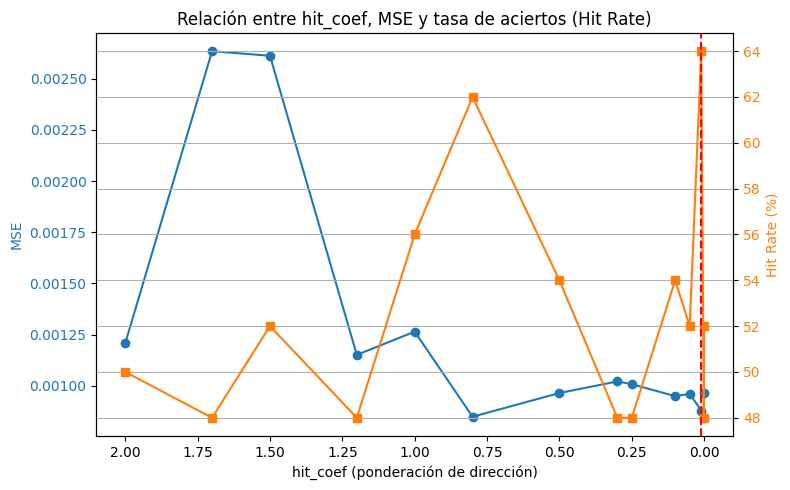

In [7]:
import matplotlib.pyplot as plt
import numpy as np

hit_rates = [hit_rate(res["res"][0], df) for res in results]
mses = [float(np.mean((res["res"][0]["y_pred_norm"] - res["res"][0]["y_true_norm"])**2)) for res in results]


# Score
lamb = 0.7  # por ejemplo, valorás más la dirección
scores = [lamb * (1 - h) + (1 - lamb) * m for h, m in zip(hit_rates, mses)]

best_index = int(np.argmin(scores))
best_hit_coef = hit_coefs[best_index]

print(f"Mejor hit_coef según score combinado (λ={lamb}): {best_hit_coef}")

# crear figura y ejes
fig, ax1 = plt.subplots(figsize=(8,5))

color1 = "#1f77b4"  # azul
color2 = "#ff7f0e"  # naranja

# --- eje izquierdo: MSE ---
ax1.set_xlabel("hit_coef (ponderación de dirección)")
ax1.set_ylabel("MSE", color=color1)
ax1.plot(hit_coefs, mses, color=color1, marker="o", label="MSE")
ax1.tick_params(axis="y", labelcolor=color1)
ax1.invert_xaxis()  # opcional: que los valores grandes de coef estén a la izquierda

# --- eje derecho: Hit Rate ---
ax2 = ax1.twinx()
ax2.set_ylabel("Hit Rate (%)", color=color2)
ax2.plot(hit_coefs, np.array(hit_rates)*100, color=color2, marker="s", label="Hit Rate")
ax2.tick_params(axis="y", labelcolor=color2)

# título y estética
plt.title("Relación entre hit_coef, MSE y tasa de aciertos (Hit Rate)")
fig.tight_layout()
plt.axvline(x=best_hit_coef, color='red', linestyle='--')
plt.grid()
plt.show()

In [ ]:
# TRAINING
##########
results = []
hit_coefs = [0, 0.001, 0.01, 0.05, 0.1, 0.25, 0.3, 0.5, 0.8, 1, 1.2, 1.5, 1.7, 2]
for hit_coef in hit_coefs:
    res = walk_forward_predict(     LSTMRegressor,
                                    df, 
                                    start_day, 
                                    horizon_days,
                                    training_years=training_years,
                                    feat_cols=feat_cols,

                                    W=50,
                                    
                                    hidden_size=64, 
                                    num_layers=2, 
                                    dropout=0.5,
                                    hit_coef=hit_coef,
                                    batch_size=11, 
                                    epochs=30, 
                                    lr=0.005,

                                    patience=10,
                                    loss_validation=True,
                                    
                                    torch_seed=0
                                )
    
    res_df = res[0]
    mse = float(np.mean((res_df["y_pred_norm"] - res_df["y_true_norm"])**2))
    _hit_rate = hit_rate(res[0], df)
    print(f"hit_coef = {hit_coef} | MSE = {mse:.6} | Hit Rate = {_hit_rate:.2%} ")
    results.append({
        "stock": stock,
        "hit_coef":hit_coef,
        "res":res,
        "mse":mse
    })